# Exploratory Data Analysis

## 1. Notebook overview and imports 

This notebook performs an exploratory analysis of the IBM HR Analytics Employee Attrition dataset. 
The primary objectives of this notebook are to:

- Understand the structure and distribution of the dataset.
- Investigate the target variable `Attrition` and its class balance.
- Explore feature distributions, trends, and relationships with attrition.

In [1]:
# Imports for data loading and EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid', palette='muted')
plt.rcParams['figure.figsize'] = (10, 6)

# Set random seed for reproducibility
RANDOM_STATE = 42

# Readability
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## 2. Load and validate data

In this section, we load the original IBM HR Analytics dataset from the `data/raw/` directory. We verify the dataset was read correctly and perform a basic inspection using `.shape`, `.head()`, and 
`.info()` to confirm data types and structure.

Dataset overview and initial inspection

- We begin by loading the dataset and inspecting its structure using `.head()` and `.info()`.
    - Shape: The dataset contains 1470 rows × 35 columns.
    - Target Variable: `Attrition`, which is a binary categorical variable with values `Yes` (left the company) and `No` (stayed).
    - Data types:
        - `int64`: 26 columns — these are numerical features (`Age`, `MonthlyIncome`, `DistanceFromHome`, etc.).
        - `object`: 9 columns — these are categorical features (`Gender`, `JobRole`, `BusinessTravel`, etc.).
    - No null values:
      - According to `.info()`, there are no missing values in any column. This simplifies preprocessing and allows us to proceed directly with encoding and scaling.
  
- Columns requiring attention before modeling
    - Categorical Variables (object dtype):
      - These need to be one-hot encoded before logistic regression, as the model requires all inputs to be numeric.
    - Constant or non-informative columns (to be dropped):
        - `EmployeeNumber`: Identifier only; does not carry predictive value.
        - `EmployeeCount`: Constant value of 1 across all rows.
        - `Over18`: Constant value "Y" for all entries.
        - `StandardHours`: Constant value (80 for all employees).
    - These will be removed to avoid introducing noise or unnecessary dimensionality.

In [2]:
# Define path to raw data file
data_path = "../data/raw/original_data.csv"

# Load the dataset into a pandas DataFrame
df = pd.read_csv(data_path)

# Display basic information
print("Shape of dataset:", df.shape)
display(df.head())
display(df.info())

Shape of dataset: (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

None

### Column validation 

- A validation step is performed to ensure that all expected columns are present and no extra or missing columns exist. This helps catch data corruption or schema mismatches early in the pipeline.
- Result: all expected columns are confirmed to be present and are correctly named (no spaces, misspellings, etc.).

In [3]:
# Define expected columns (based on known structure of IBM HR dataset)
expected_columns = [
    'Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
    'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
    'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
    'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
    'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime',
    'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
    'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
    'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
    'YearsWithCurrManager'
]

# Get actual columns
actual_columns = list(df.columns)

# Check for unexpected or missing columns
missing_columns = set(expected_columns) - set(actual_columns)
unexpected_columns = set(actual_columns) - set(expected_columns)

# Print results
if not missing_columns and not unexpected_columns:
    print("Column check passed: All expected columns are present.")
else:
    if missing_columns:
        print("Missing columns:", missing_columns)
    if unexpected_columns:
        print("Unexpected columns:", unexpected_columns)


Column check passed: All expected columns are present.


### Drop non-informative columns

- After validating the schema, columns that do not provide meaningful information are removed:
    - `EmployeeNumber`: Unique identifier; has no statistical relationship with attrition, and no merges are necessary (only one table). 
    - `EmployeeCount`, `Over18`, `StandardHours`: Constant values across all rows.
- Removing these columns at this early stage simplifies the dataset and prevents them from accidentally influencing the data analysis or model. 

In [4]:
# Drop constant or ID-like columns that provide no predictive value
columns_to_drop = ['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber']
df.drop(columns=columns_to_drop, inplace=True)

print("Dropped columns:", columns_to_drop)
print("New shape:", df.shape)

Dropped columns: ['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber']
New shape: (1470, 31)


In [41]:
# Export cleaned DataFrame to CSV for use in the next notebook
try:
    df.to_csv('../data/processed/data_01.csv', index=False)
except Exception as e:
    print(f"Error exporting DataFrame: {e}")
else:
    print("Data successfully exported to './data/processed/data_01.csv'")
finally:
    print("Export attempt completed.")

Data successfully exported to './data/processed/data_01.csv'
Export attempt completed.


## 3. Initial Data Summary

The dataset has 1,470 rows and 31 columns, with no missing values.

- Numeric features like `MonthlyIncome` and `MonthlyRate` have wide ranges and will require scaling. Numeric features with relatively high ranges like `YearsAtCompany` (range = 40) will also benefit from scaling. 
- Categorical features have low to moderate cardinality (max = 9), making them suitable for one-hot encoding.
- Ordinal features (`Education`, `JobLevel`, satisfaction scores) are already numerically encoded and can be used as-is.

In [5]:
# Dataset dimensions
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

# Data types and non-null counts
display(df.info())

# Summary statistics for numerical columns
display(df.describe())

# Count of unique values per column (including categoricals)
unique_counts = df.nunique().sort_values()
print("Unique values per column:")
display(unique_counts)

Number of rows: 1470
Number of columns: 31
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   int64 
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int64 
 11  JobInvolvement            1470 non-null   int64 
 12  JobLevel                  1470 non-null   int64 
 13  JobRole                   1470 non-

None

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


Unique values per column:


Attrition                      2
Gender                         2
PerformanceRating              2
OverTime                       2
MaritalStatus                  3
BusinessTravel                 3
Department                     3
JobInvolvement                 4
StockOptionLevel               4
RelationshipSatisfaction       4
EnvironmentSatisfaction        4
WorkLifeBalance                4
JobSatisfaction                4
Education                      5
JobLevel                       5
EducationField                 6
TrainingTimesLastYear          7
JobRole                        9
NumCompaniesWorked            10
PercentSalaryHike             15
YearsSinceLastPromotion       16
YearsWithCurrManager          18
YearsInCurrentRole            19
DistanceFromHome              29
YearsAtCompany                37
TotalWorkingYears             40
Age                           43
HourlyRate                    71
DailyRate                    886
MonthlyIncome               1349
MonthlyRat

### Target Variable Distribution: `Attrition`

- 83.88% of employees stayed (No)
- 16.12% of employees left (Yes)

- This indicates a moderate class imbalance. While not extreme, it’s enough to warrant mitigation strategies such as:
  - Using `class_weight='balanced'` in logistic regression
  - Evaluating with ROC-AUC, precision, and recall, not just accuracy

In [6]:
# Count of each class
attrition_counts = df['Attrition'].value_counts()
attrition_percent = df['Attrition'].value_counts(normalize=True) * 100

# Combine into a summary table
attrition_summary = pd.DataFrame({
    'Count': attrition_counts,
    'Percentage': attrition_percent.round(2)
})

display(attrition_summary)

,Count,Percentage
Attrition,,
No,1233,83.88
Yes,237,16.12


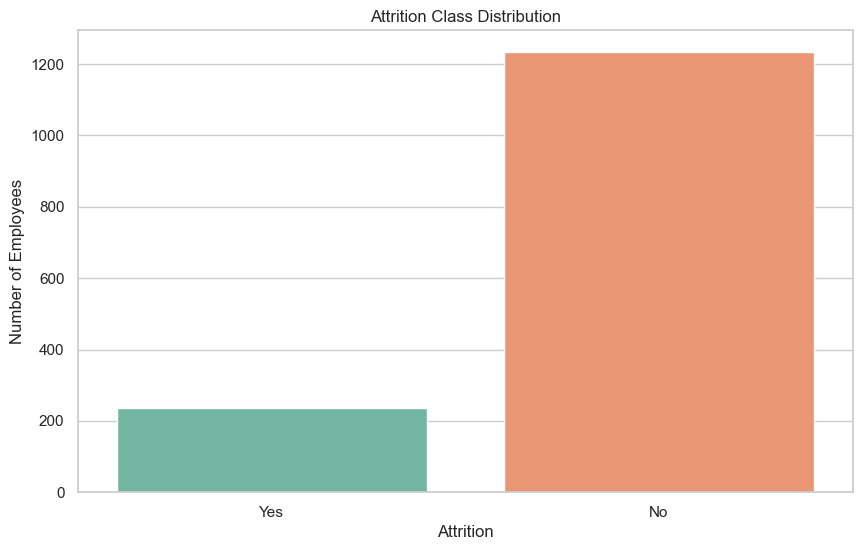

In [7]:
# Bar plot of attrition distribution
sns.countplot(data=df, x='Attrition', palette='Set2')
plt.title("Attrition Class Distribution")
plt.ylabel("Number of Employees")
plt.xlabel("Attrition")
plt.show()

## 4. Univariate Analysis

We analyze the distribution of each feature independently to understand the spread and identify potential outliers or skewed variables.

- Numeric features: visualized using histograms and boxplots.
- Categorical features: visualized using countplots to show category frequency.

### Numeric features

- Right-skewed distributions are observed in `MonthlyIncome`, `TotalWorkingYears`, `YearsAtCompany`, and `DistanceFromHome`, indicating that most employees are clustered at lower values. 
  - These may benefit from log transformation to reduce the influence of extreme values.

- Stepped distributions appear in ordinal features like `Education`, `JobLevel`, `JobInvolvement`, and the various satisfaction scores. 
  - These represent categorical levels encoded as integers and can be left unscaled.

- Variables such as `YearsSinceLastPromotion`, `YearsWithCurrManager`, and `NumCompaniesWorked` show strong peaks at zero, capturing employees with no prior experience, recent role changes, or long periods without advancement. 
  - These may have nonlinear effects on attrition:
    - For example, the risk of attrition might stay flat for several years, then spike suddenly after a long period without promotion or job change.

- Salary-related variables (`HourlyRate`, `DailyRate`, `MonthlyRate`, `MonthlyIncome`) have differing scales and shapes, making standardization essential for logistic regression to ensure fair weight distribution across features.

#### Demographics

- This section explores three demographic variables: `Age`, `DistanceFromHome`, and `Education`.
  - `Age` shows a slightly right-skewed distribution, with most employees between 30 and 40 years old.
  - `DistanceFromHome` is heavily right-skewed, indicating that most employees live within 10 km of the workplace.
  - `Education` is a categorical feature, with a relatively balanced spread across levels, peaking at level 3.

- Boxplots confirm distribution patterns and highlight outliers in `DistanceFromHome`. These features may relate to attrition through commute stress, career stage, or qualification mismatch.


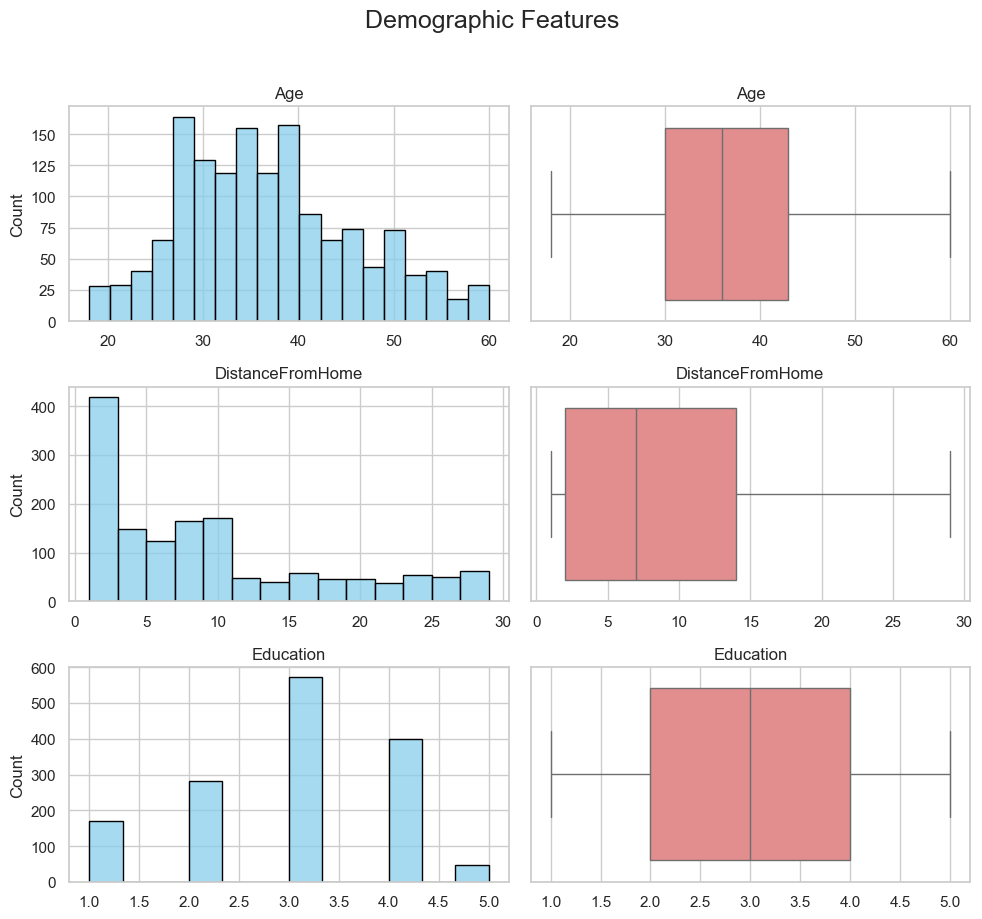

In [8]:
# Demographic Features
demographics = ['Age', 'DistanceFromHome', 'Education']

fig, axes = plt.subplots(nrows=len(demographics), ncols=2, figsize=(10, len(demographics) * 3))
fig.suptitle('Demographic Features', fontsize=18, y=1.02)

for i, col in enumerate(demographics):
    sns.histplot(data=df, x=col, ax=axes[i, 0], color='skyblue', edgecolor='black')
    axes[i, 0].set_title(f'{col}')
    axes[i, 0].set_xlabel('')  # Remove x-axis label

    sns.boxplot(data=df, x=col, ax=axes[i, 1], color='lightcoral')
    axes[i, 1].set_title(f'{col}')
    axes[i, 1].set_xlabel('')  # Remove x-axis label

plt.tight_layout()
plt.show()


#### Compensation

> **Note:** Although `StockOptionLevel` is an **ordinal categorical variable** representing discrete levels (0–3), we treat it as numerical here purely for the purpose of visualizing its distribution. For modeling, it should be treated as a categorical feature to avoid implying linear relationships between the levels.
  
- This section examines compensation-related variables: `HourlyRate`, `DailyRate`, `MonthlyIncome`, `MonthlyRate`, `PercentSalaryHike`, and `StockOptionLevel`.
  - `HourlyRate`, `DailyRate`, and `MonthlyRate` appear uniformly distributed, suggesting limited variation or artificial assignment.
  - `MonthlyIncome` is right-skewed with a long tail and several high outliers, indicating a wide income disparity among employees.
  - `PercentSalaryHike` is moderately skewed right, with most employees receiving raises between 11% and 15%.
  - `StockOptionLevel` is heavily concentrated at 0, with relatively few employees receiving higher stock options.
- The distributions suggest that while most compensation variables are evenly spread, income and salary hikes may correlate with seniority or performance.


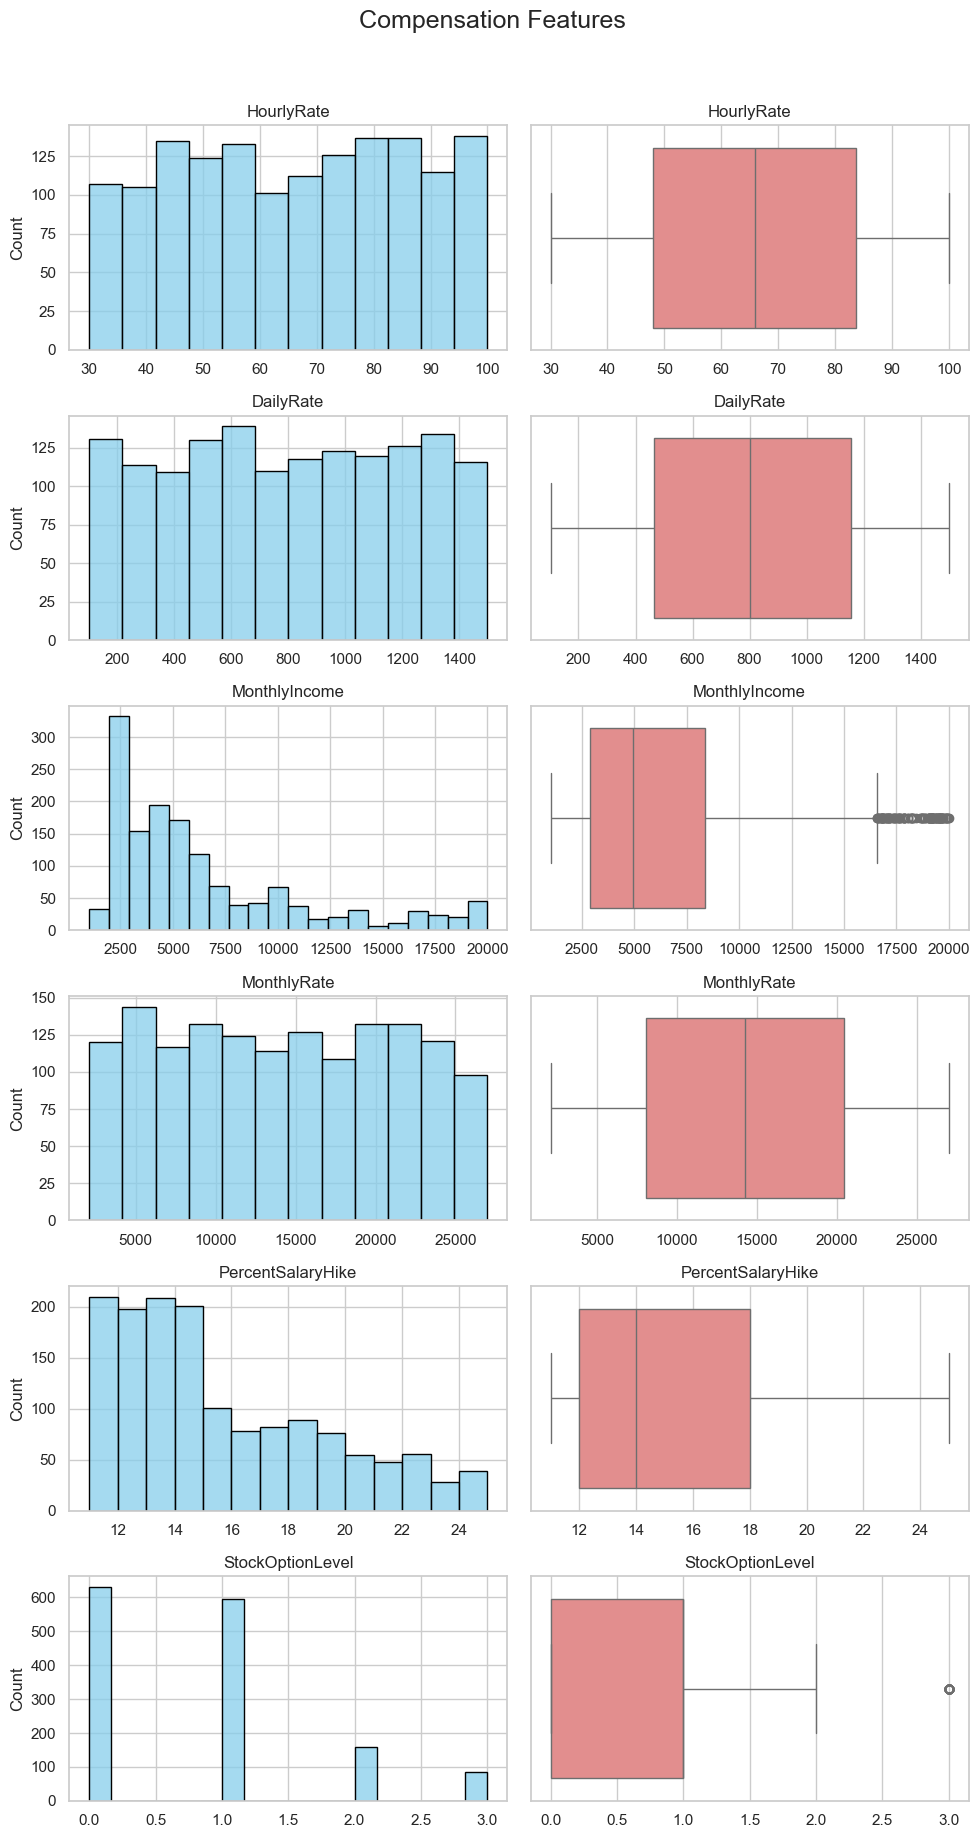

In [9]:
# Compensation features
compensation = ['HourlyRate', 'DailyRate', 'MonthlyIncome', 'MonthlyRate',
                'PercentSalaryHike', 'StockOptionLevel']

fig, axes = plt.subplots(nrows=len(compensation), ncols=2, figsize=(10, len(compensation) * 3))
fig.suptitle('Compensation Features', fontsize=18, y=1.02)

for i, col in enumerate(compensation):
    sns.histplot(data=df, x=col, ax=axes[i, 0], color='skyblue', edgecolor='black')
    axes[i, 0].set_title(f'{col}')
    axes[i, 0].set_xlabel('')  # Remove x-axis label

    sns.boxplot(data=df, x=col, ax=axes[i, 1], color='lightcoral')
    axes[i, 1].set_title(f'{col}')
    axes[i, 1].set_xlabel('')  # Remove x-axis label

plt.tight_layout()
plt.show()


#### Satisfaction and engagement

- This section explores variables related to employee satisfaction and engagement: `EnvironmentSatisfaction`, `JobInvolvement`, `JobLevel`, `JobSatisfaction`, `PerformanceRating`, `RelationshipSatisfaction`, and `WorkLifeBalance`.
  - `EnvironmentSatisfaction`, `JobSatisfaction`, and `RelationshipSatisfaction` all show higher counts at levels 3 and 4, suggesting most employees report moderate to high satisfaction.
  - `JobInvolvement` is heavily skewed toward level 3, indicating a generally engaged workforce.
  - `JobLevel` is concentrated at levels 1 and 2, implying that most employees are at the lower rungs of the organizational hierarchy.
  - `PerformanceRating` is almost entirely at level 3, perhaps due to a lack of variation in evaluations.
  - `WorkLifeBalance` shows a strong skew toward level 3 as well, though a notable portion reports poor balance (level 1).
- These features suggest that most employees feel moderately satisfied and involved, though upward mobility and performance differentiation appear limited.


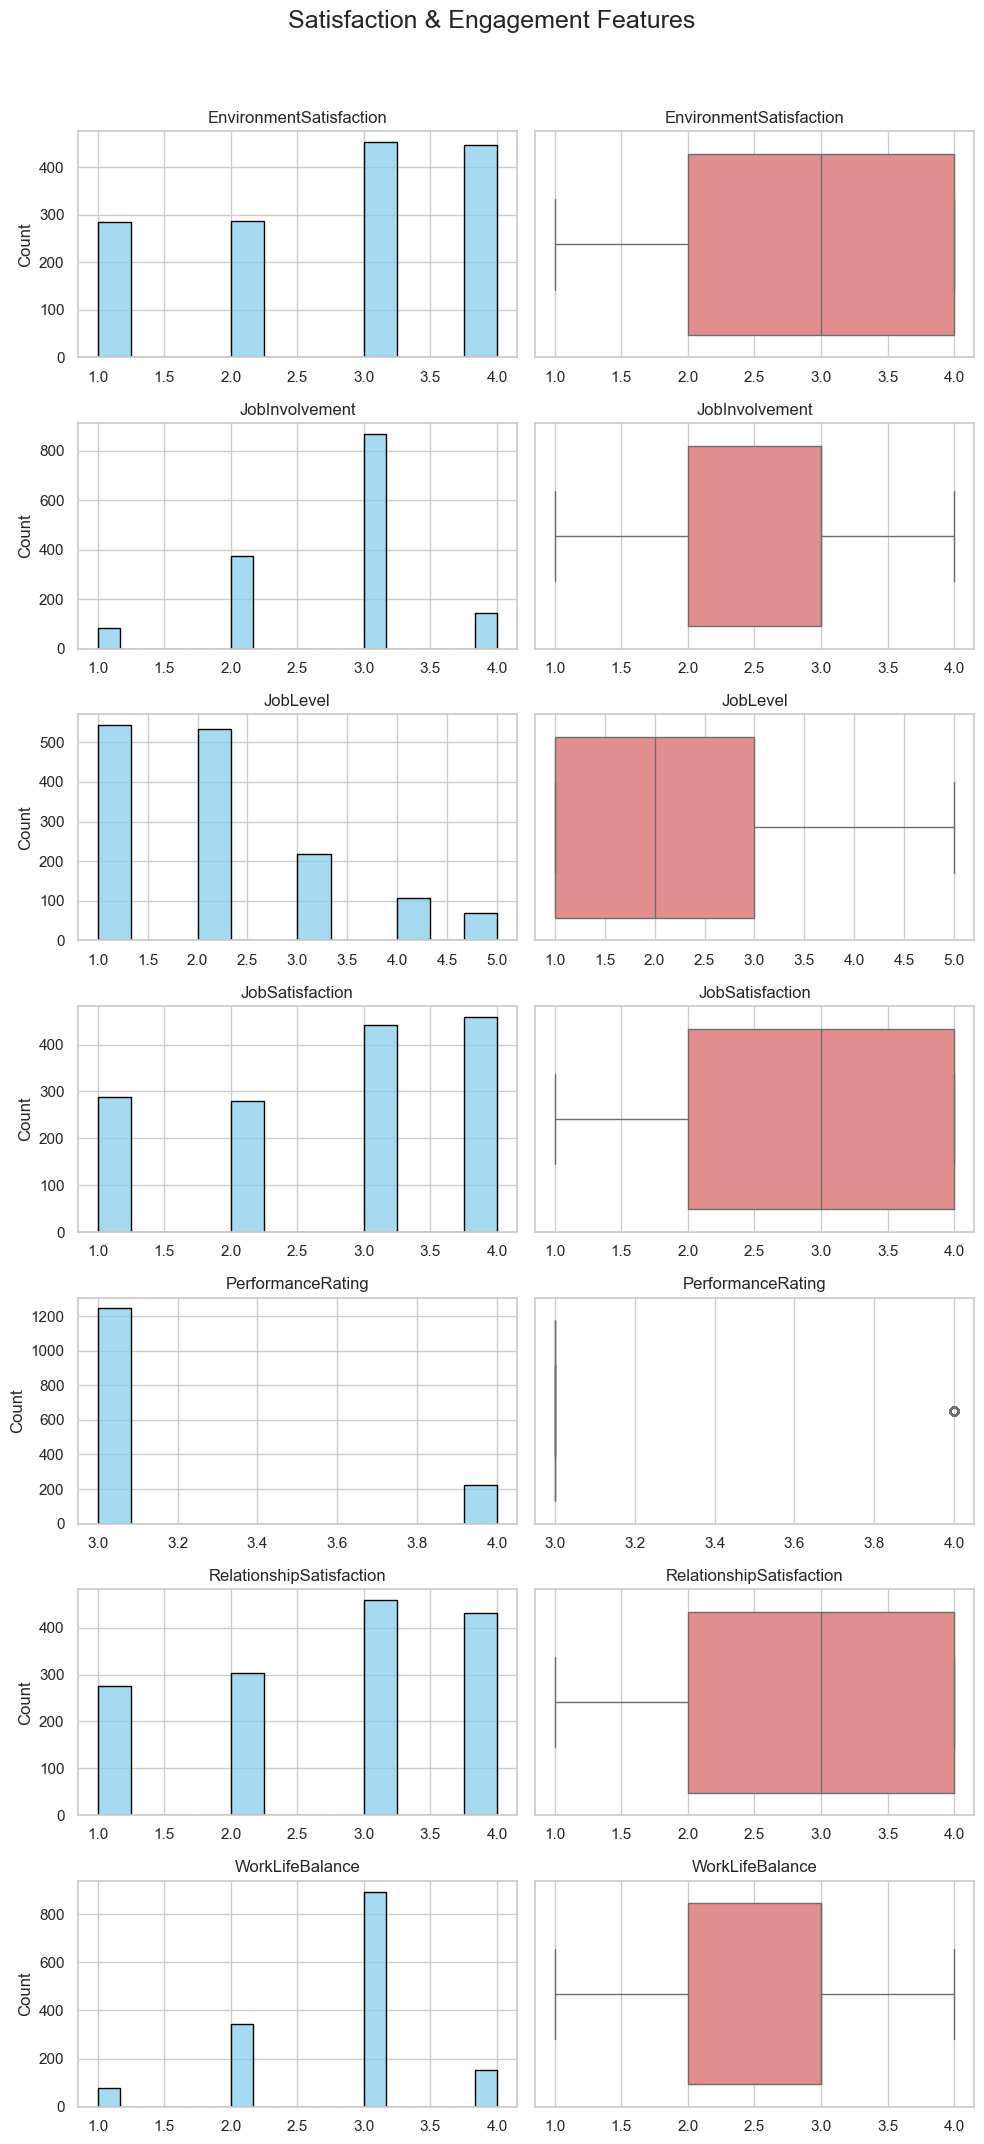

In [10]:
# Satisfaction and engagement
satisfaction = ['EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction',
                'PerformanceRating', 'RelationshipSatisfaction', 'WorkLifeBalance']

fig, axes = plt.subplots(nrows=len(satisfaction), ncols=2, figsize=(10, len(satisfaction) * 3))
fig.suptitle('Satisfaction & Engagement Features', fontsize=18, y=1.02)

for i, col in enumerate(satisfaction):
    sns.histplot(data=df, x=col, ax=axes[i, 0], color='skyblue', edgecolor='black')
    axes[i, 0].set_title(f'{col}')
    axes[i, 0].set_xlabel('')  # Remove x-axis label

    sns.boxplot(data=df, x=col, ax=axes[i, 1], color='lightcoral')
    axes[i, 1].set_title(f'{col}')
    axes[i, 1].set_xlabel('')  # Remove x-axis label

plt.tight_layout()
plt.show()

#### Tenure and career

- This section explores features related to employee tenure, promotion history, and company experience.
  - `TotalWorkingYears`, `YearsAtCompany`, and `YearsInCurrentRole` display long right tails, indicating a small group of highly tenured individuals.
  - `TrainingTimesLastYear` shows distinct spikes, most commonly at 2–3 training sessions.
  - `YearsSinceLastPromotion` is skewed toward recent promotions, though some employees have not been promoted for over a decade.
  - `YearsWithCurrManager` is right-skewed but shows clustering at low values, suggesting frequent managerial changes.
  - `NumCompaniesWorked` also has a right-skewed distribution, with many employees having worked at one or two companies, and fewer with broader external experience.
- Employees tend to cluster around short-to-mid career stages, with relatively few long-tenured individuals. 
- Promotions are infrequent, suggesting potential stagnation or limited upward mobility.

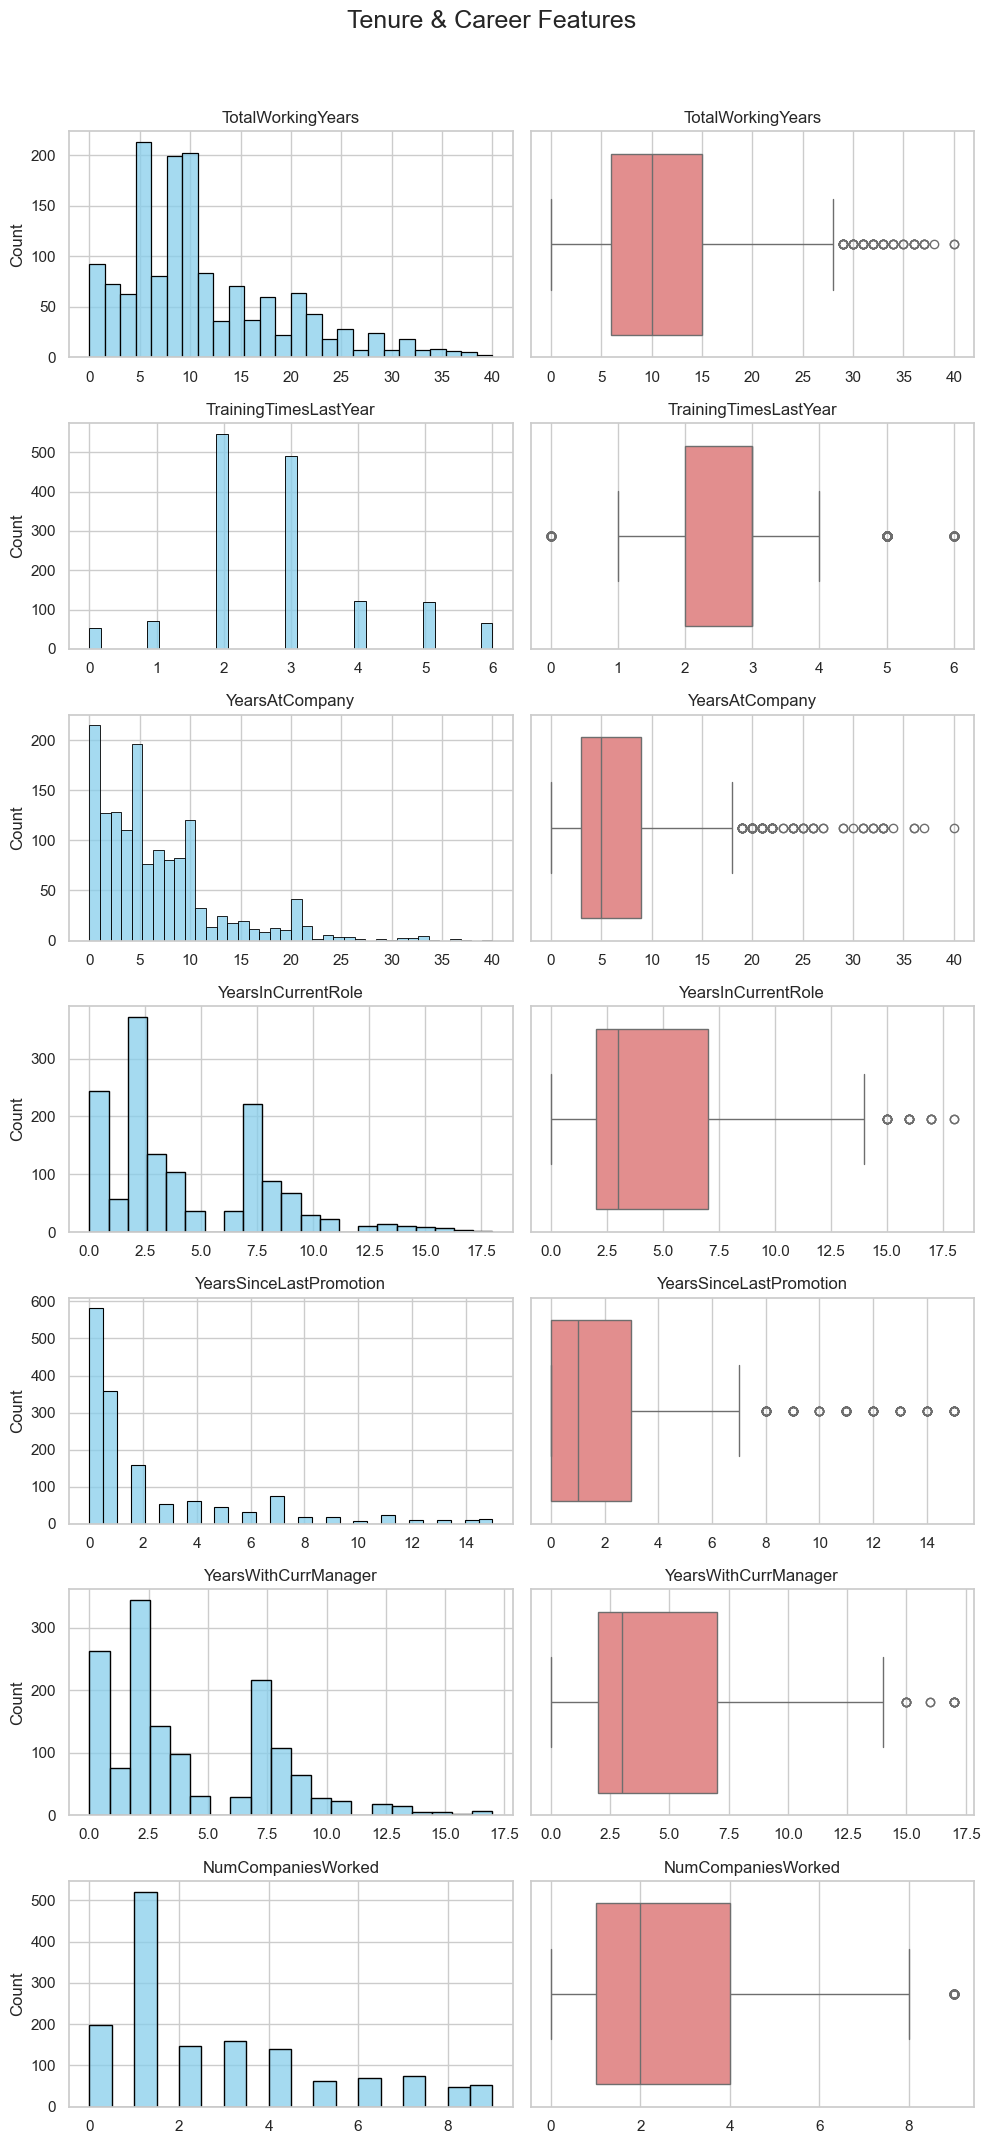

In [11]:
# Tenure & Career Features
tenure = ['TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole',
          'YearsSinceLastPromotion', 'YearsWithCurrManager', 'NumCompaniesWorked']

fig, axes = plt.subplots(nrows=len(tenure), ncols=2, figsize=(10, len(tenure) * 3))
fig.suptitle('Tenure & Career Features', fontsize=18, y=1.02)

for i, col in enumerate(tenure):
    sns.histplot(data=df, x=col, ax=axes[i, 0], color='skyblue', edgecolor='black')
    axes[i, 0].set_title(f'{col}')
    axes[i, 0].set_xlabel('')  # Remove x-axis label

    sns.boxplot(data=df, x=col, ax=axes[i, 1], color='lightcoral')
    axes[i, 1].set_title(f'{col}')
    axes[i, 1].set_xlabel('')  # Remove x-axis label

plt.tight_layout()
plt.show()

### Categorical features 

#### Role and department

- This section examines categorical variables related to an employee’s department, job role, and field of education.
  - `Department` is dominated by employees in `Research & Development`, followed by `Sales`, with very few in `Human Resources`.
  - `JobRole` shows more diversity, with a relatively balanced distribution among `Sales Executive`, `Research Scientist`, and `Laboratory Technician`, and lower representation for director-level roles.
  - `EducationField` is concentrated in `Life Sciences` and `Medical`, with other fields such as `Marketing` and `Technical Degree` trailing behind.

- The majority of employees are concentrated in technical and scientific fields, with a clear imbalance in department and education field representation.

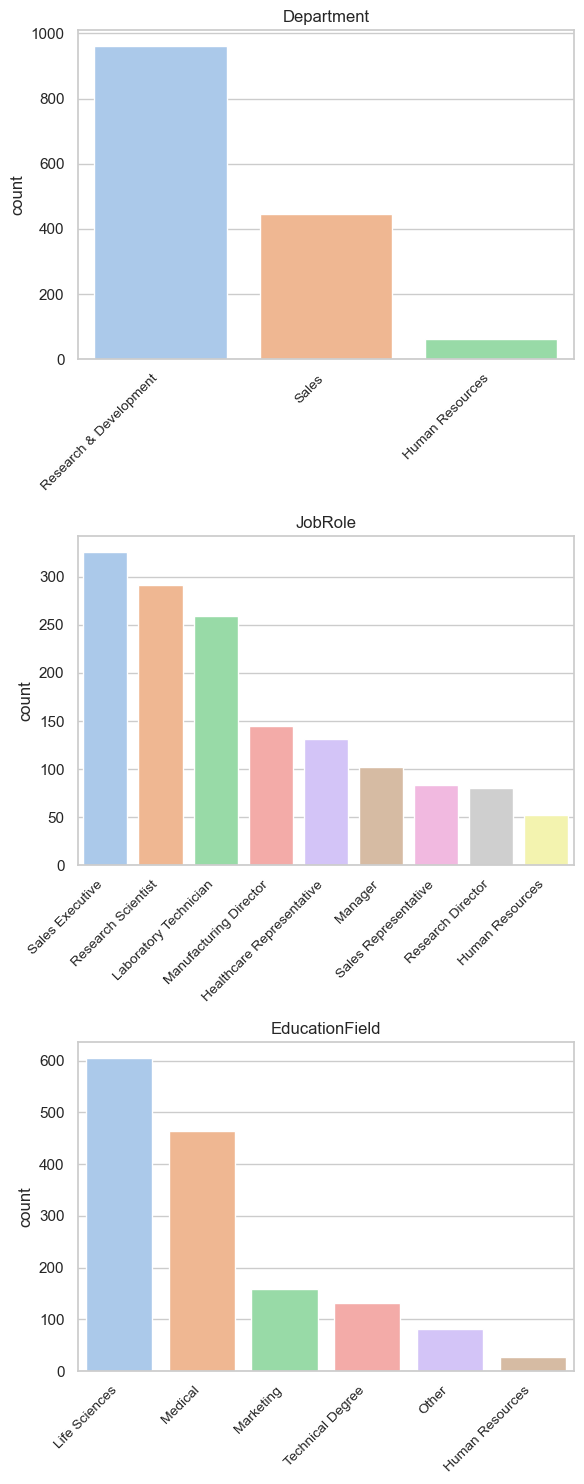

In [5]:
# Plot role & department features vertically
cols_role = ['Department', 'JobRole', 'EducationField']

plt.figure(figsize=(6, 15))  # taller and narrower figure for vertical layout
for idx, col in enumerate(cols_role, 1):
    plt.subplot(3, 1, idx)
    sns.countplot(data=df, x=col, palette='pastel', order=df[col].value_counts().index)
    plt.title(col)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.xlabel("")  # optional: remove x-axis label
    plt.tight_layout()

plt.show()

#### Demographics

- `Gender` shows a roughly 60/40 split between male and female.

- `MaritalStatus` shows that a majority of employees are married, followed by single and divorced individuals.
  - The higher proportion of married employees may correlate with longer tenure or reduced attrition, warranting further analysis of how marital status interacts with stability-related features like `YearsAtCompany` or `Attrition`.

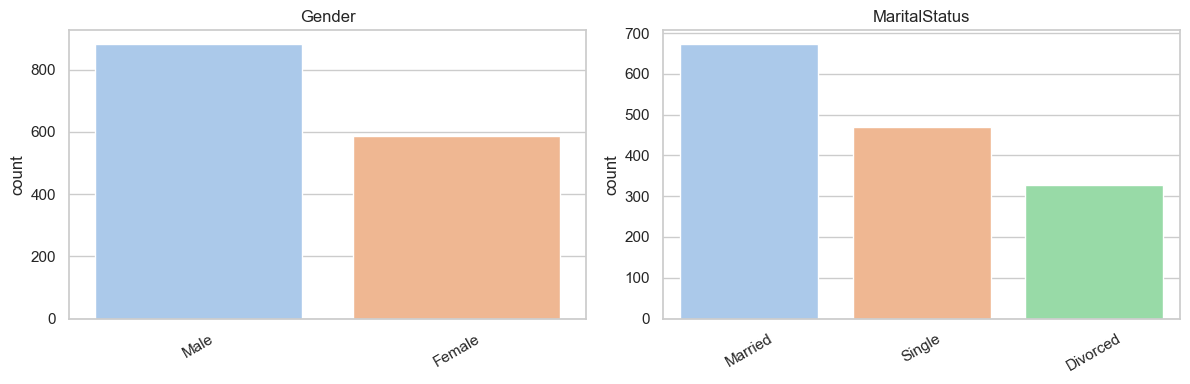

In [13]:
# Plot Demographics features
cols_demo = ['Gender', 'MaritalStatus']

plt.figure(figsize=(18, 4))
for idx, col in enumerate(cols_demo, 1):
    plt.subplot(1, 3, idx)
    sns.countplot(data=df, x=col, palette='pastel', order=df[col].value_counts().index)
    plt.title(col)
    plt.xticks(rotation=30)
    plt.xlabel("")
plt.tight_layout()
plt.show()

#### Work pattern

- This section explores employee work patterns via `BusinessTravel` and `OverTime`.
  - Most employees either travel rarely for business or not at all. Very few travel frequently.
  - The majority of employees do not work overtime, though a substantial minority does.

- Overtime may be a stronger indicator of workplace strain than business travel. 
  - Given that frequent travelers are few, but overtime workers still make up a visible proportion of the dataset, it may be worth investigating whether `OverTime == Yes` correlates with burnout indicators or higher attrition risk. 
  - Follow-up analysis could include comparing average `MonthlyIncome`, `JobSatisfaction`, or `Attrition` rates between overtime and non-overtime groups.

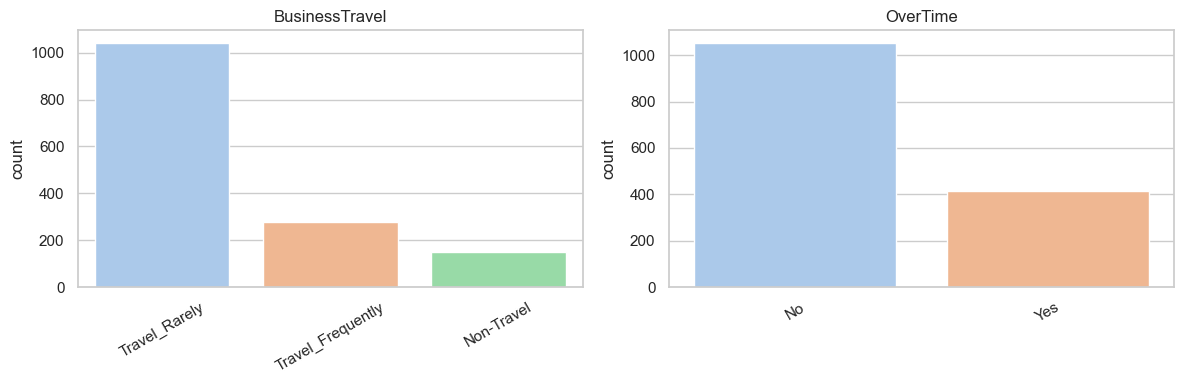

In [14]:
# Plot Work Pattern features
cols_work = ['BusinessTravel', 'OverTime']

plt.figure(figsize=(12, 4))
for idx, col in enumerate(cols_work, 1):
    plt.subplot(1, 2, idx)
    sns.countplot(data=df, x=col, palette='pastel', order=df[col].value_counts().index)
    plt.title(col)
    plt.xticks(rotation=30)
    plt.xlabel("")
plt.tight_layout()
plt.show()

## 5. Feature Relationships to `Attrition`

This section explores how each feature relates to the target variable `Attrition`.

We examine:
- **Numeric Features**: using violin and box plots to visualize differences in distributions between attrition classes.
- **Categorical Features**: using stacked bar plots to understand how category frequencies vary by attrition status.

These comparisons help identify features with strong predictive potential.

### Numeric features vs `Attrition`

#### Demographics

- These violin plots compare demographic features across attrition groups:
  - `Age`: Employees who left skew younger, with a noticeable peak in the late 20s–30s range. Those who stayed are more evenly distributed across older age groups, suggesting that younger employees may be more prone to leave.
  - `DistanceFromHome`: There's a wider spread for employees who left, indicating that longer commutes might correlate with higher attrition risk.
  - `Education`: Distributions are similar across both groups, implying that education level likely has minimal impact on attrition.

- Overall, `Age` and `DistanceFromHome` may be useful predictors, while `Education` appears less relevant.


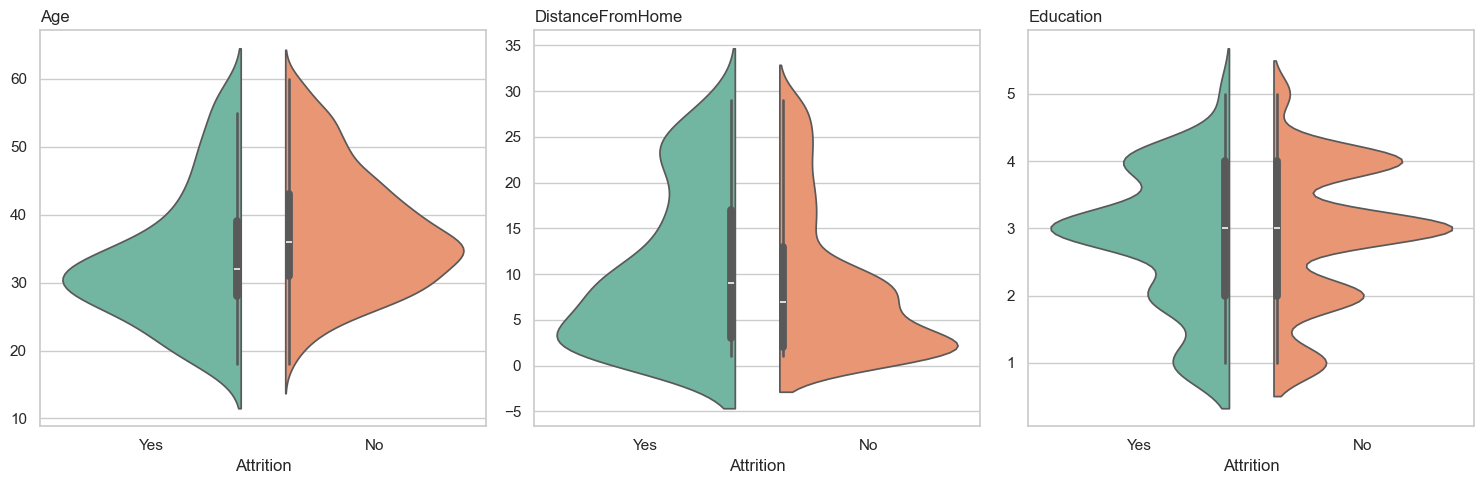

In [15]:
# Demographic Features with hue='Attrition'
demographics = ['Age', 'DistanceFromHome', 'Education']

plt.figure(figsize=(len(demographics) * 5, 5))
for i, col in enumerate(demographics):
    plt.subplot(1, len(demographics), i+1)
    sns.violinplot(x='Attrition', y=col, data=df, hue='Attrition', split=True, inner='box', palette='Set2', legend=False)
    plt.title(col, loc='left')  # Left-align the title
    plt.ylabel("")

plt.tight_layout()
plt.show()

#### Compensation

> **Note:** Although `StockOptionLevel` is an **ordinal categorical variable** representing discrete levels (0–3), we treat it as numerical here purely for the purpose of visualizing its distribution. For modeling, it should be treated as a categorical feature to avoid implying linear relationships between the levels.

- The violin plots below show the distribution of compensation-related features across attrition status. 
  - `MonthlyIncome`: Employees who stayed tend to have a higher and more widely distributed income. Those who left cluster more tightly around lower income levels. 
    - This may indicate that employees with lower salaries are more likely to leave, either due to financial dissatisfaction or better-paying opportunities elsewhere.

  - `PercentSalaryHike`: There is a subtle difference where retained employees received slightly more frequent or higher salary hikes. 
    - Although the difference is modest, a small cumulative effect over time might influence retention.

  - `StockOptionLevel`: Employees who stayed had slightly more presence at higher stock option levels. 
    - This may reflect better long-term incentives provided to retained employees, suggesting stock options could act as a retention lever.

  - Other compensation variables like `HourlyRate`, `DailyRate`, and `MonthlyRate` do not show strong separation, suggesting they may be less influential or redundant with `MonthlyIncome`.

- Overall, the plots suggest that compensation structure—especially total monthly income and long-term incentives like stock options—may play a meaningful role in employee attrition risk.


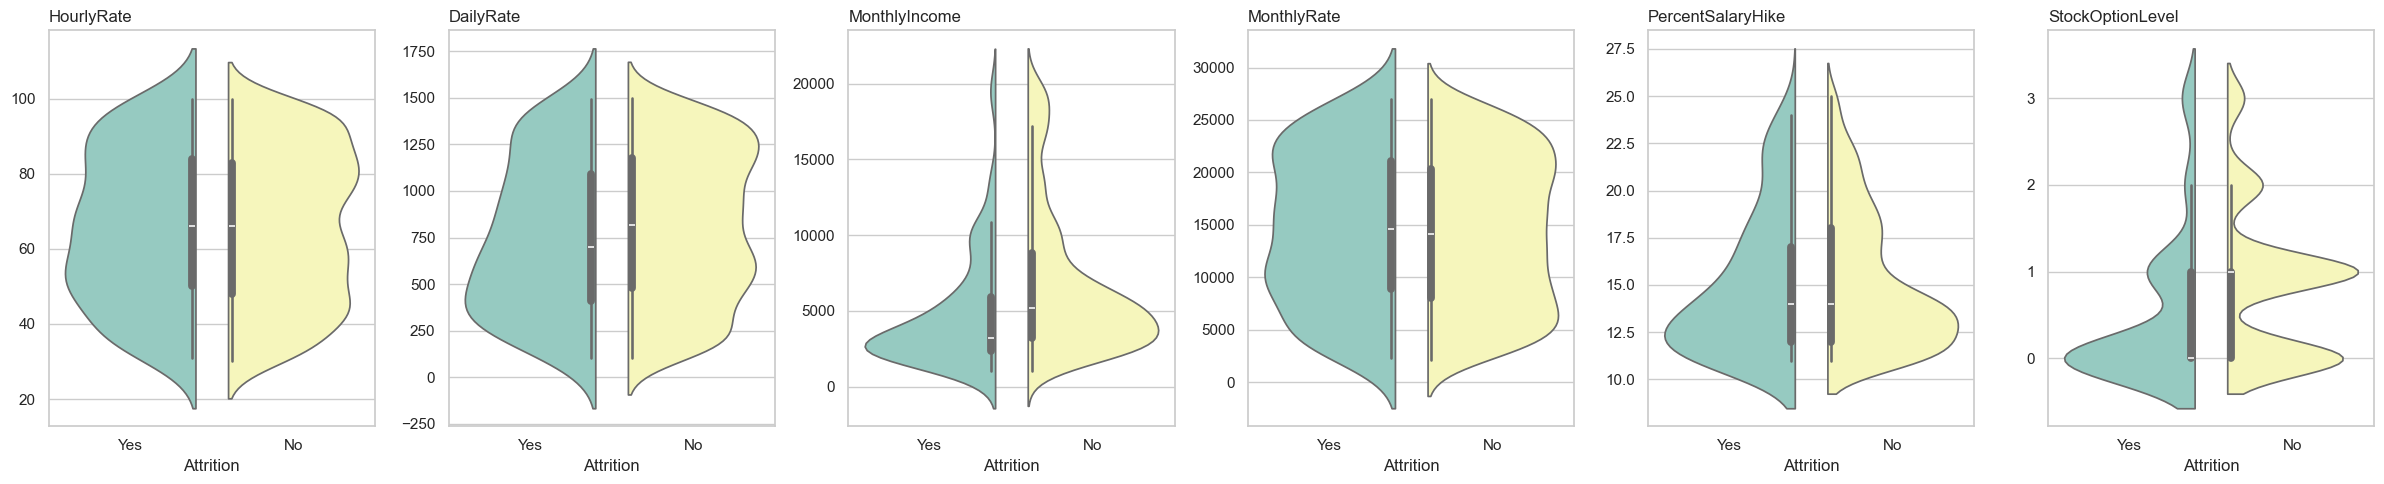

In [16]:
# Compensation Features with hue='Attrition'
compensation = [
    'HourlyRate', 'DailyRate', 'MonthlyIncome', 'MonthlyRate', 'PercentSalaryHike', 'StockOptionLevel'
]

plt.figure(figsize=(len(compensation) * 4, 5))
for i, col in enumerate(compensation):
    plt.subplot(1, len(compensation), i+1)
    sns.violinplot(x='Attrition', y=col, data=df, hue='Attrition', split=True, inner='box', palette='Set3', legend=False)
    plt.title(col, loc='left')  # Left-align the title
    plt.ylabel("")

plt.tight_layout()
plt.show()

#### Tenure and career 

- The tenure-related features reveal meaningful differences between employees who left the company and those who stayed:
  - `TotalWorkingYears`, `YearsAtCompany`, `YearsInCurrentRole`, and `YearsWithCurrManager` are all lower on average for those who left, indicating that shorter tenures are associated with higher attrition risk. This may reflect a lack of long-term engagement or satisfaction early in term of employment. 
  - `YearsSinceLastPromotion` appears concentrated at lower values for employees who left, suggesting that a lack of upward mobility or perceived career stagnation could influence attrition.
  - `NumCompaniesWorked` is much higher among those who left, which may indicate a tendency to switch jobs more frequently (or simply more years in the workforce).
  - `TrainingTimesLastYear` shows minimal separation, implying that training frequency alone may not play a decisive role in attrition.

- These patterns suggest that attrition is more common among employees with shorter tenure, fewer internal promotions, and more prior employers.


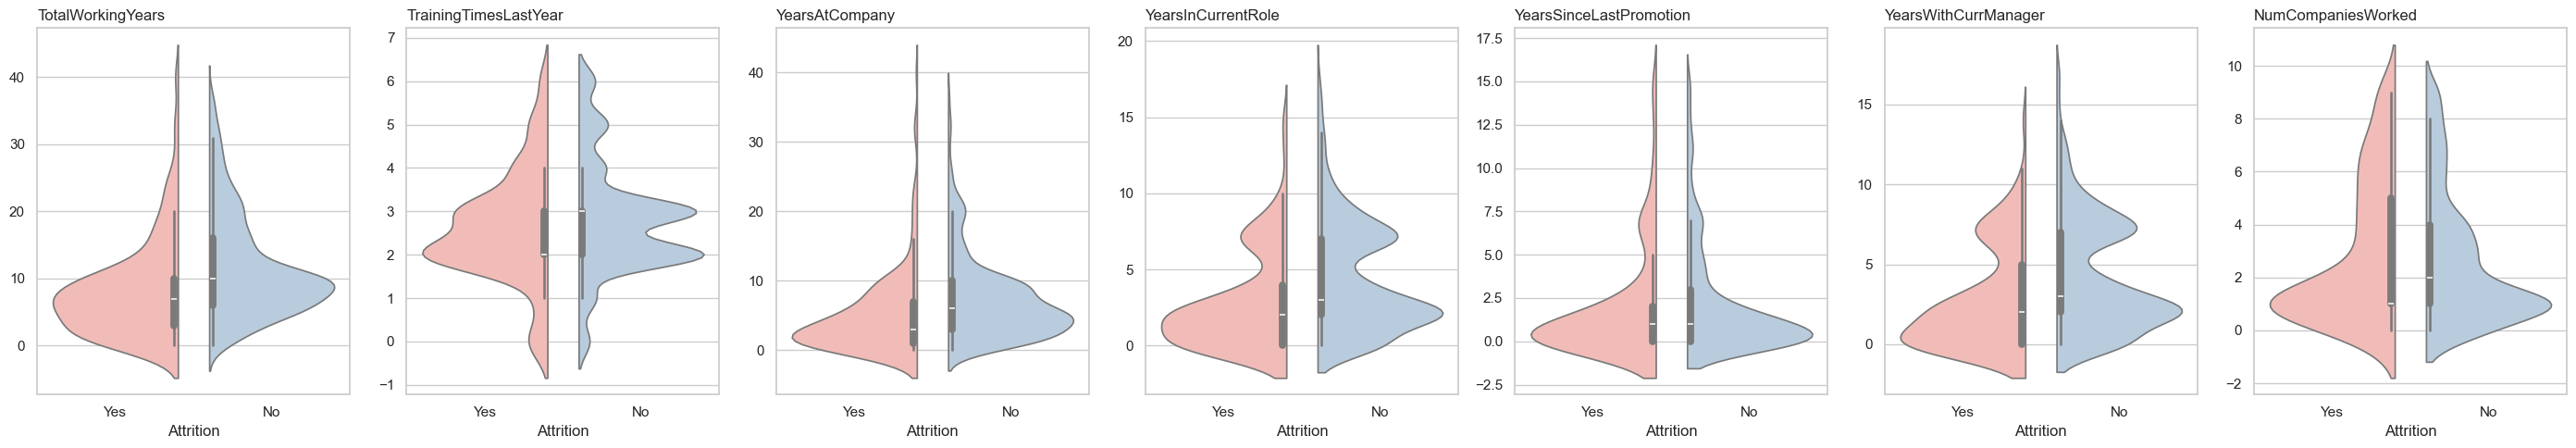

In [17]:
# Tenure & Career Features with hue='Attrition'
tenure = [
    'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
    'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
    'NumCompaniesWorked'
]

plt.figure(figsize=(len(tenure) * 4, 5))
for i, col in enumerate(tenure):
    plt.subplot(1, len(tenure), i+1)
    sns.violinplot(x='Attrition', y=col, data=df, hue='Attrition', split=True, inner='box', palette='Pastel1', legend=False)
    plt.title(col, loc='left')  # Align title to the left
    plt.ylabel("")

plt.tight_layout()
plt.show()

##### Satisfaction and engagement
  
> **NOTE**: While most features shown are ordinal categorical (`JobSatisfaction`, `WorkLifeBalance`, etc), they are treated here as quasi-continuous solely to aid visual exploration of distribution patterns and central tendencies.

- This section visualizes the distribution of satisfaction- and engagement-related variables across attrition groups using violin plots. 
  - `EnvironmentSatisfaction`: Employees who stayed tend to report slightly higher environmental satisfaction compared to those who left, though the difference is not dramatic.
  - `JobInvolvement`: Those who did not leave show a more concentrated distribution around higher involvement levels, suggesting that lower involvement may be linked to attrition.
  - `JobLevel`: Attrition appears more common among employees at lower job levels (especially level 1), while those in higher positions (levels 4–5) tend to stay.
  - `JobSatisfaction`: A higher proportion of employees with low satisfaction left the company, indicating a clear link between job satisfaction and attrition.
  - `PerformanceRating`: This feature appears largely uniform across attrition groups.
  - `RelationshipSatisfaction`: Employees with lower relationship satisfaction scores are slightly more represented among those who left.
  - `WorkLifeBalance`: Attrition is more concentrated among employees who rated their work-life balance poorly (level 1 or 2), implying a meaningful correlation.

- While not all variables show strong separation, `JobSatisfaction`, `JobInvolvement`, `WorkLifeBalance`, and `JobLevel` stand out as having visually apparent associations with attrition. 

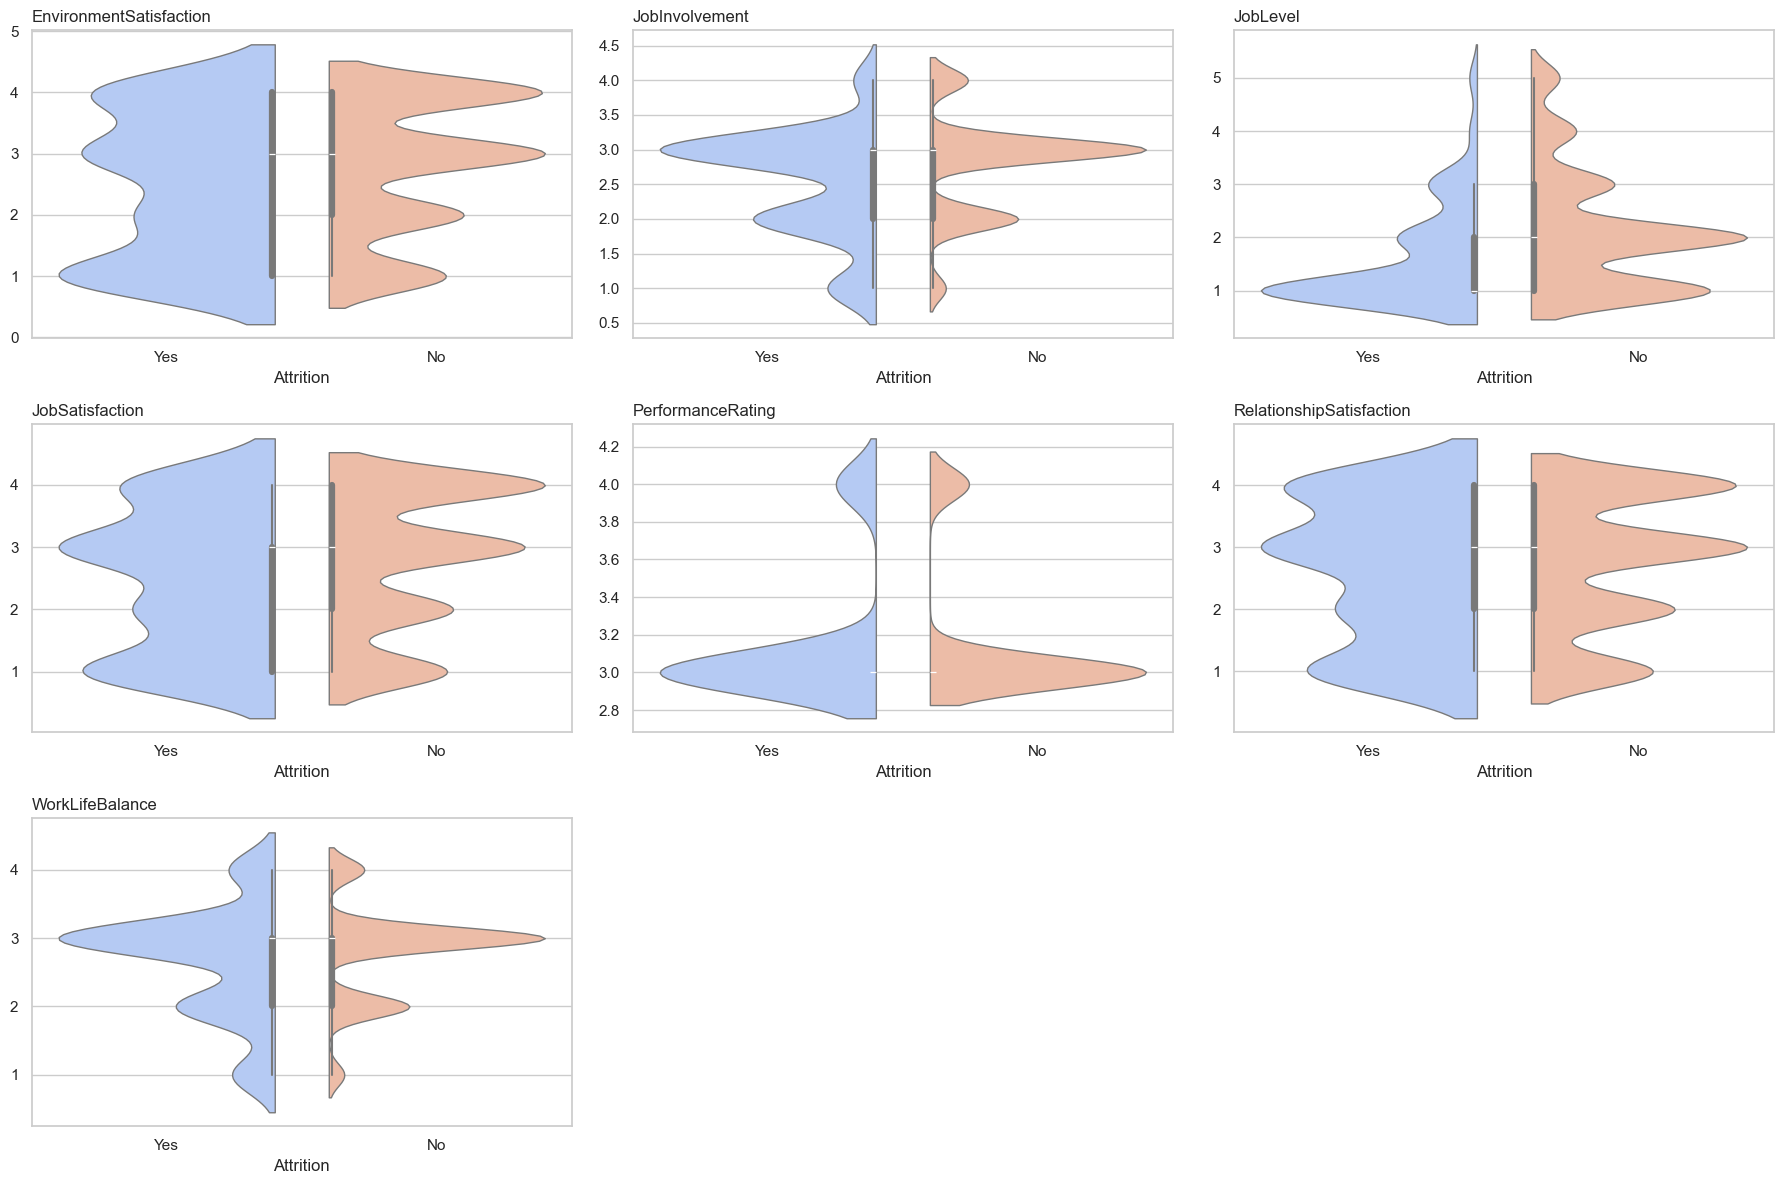

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Satisfaction & Engagement Features with hue='Attrition'
satisfaction = [
    'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel',
    'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction',
    'WorkLifeBalance'
]

fig, axes = plt.subplots(3, 3, figsize=(18, 12))  # 3x3 grid
axes = axes.flatten()  # Flatten to 1D for easy indexing

for i, col in enumerate(satisfaction):
    sns.violinplot(
        x='Attrition',
        y=col,
        data=df,
        hue='Attrition',
        split=True,
        inner='box',
        palette='coolwarm',
        linewidth=1,
        ax=axes[i]
    )
    axes[i].set_title(col, loc='left')
    axes[i].set_ylabel("")
    

# Turn off unused subplots
for j in range(len(satisfaction), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

### Categorical features vs Attrition

#### Role and department breakdown

- The bar plots display attrition rates across different categorical groups within `Department`, `JobRole`, and `EducationField`:
  - `Department`: Attrition is highest in the `Human Resources` and `Sales` departments. `Research & Development` has the lowest relative attrition, indicating greater retention in technical or core product roles.
  - `JobRole`: The proportion of attrition varies significantly across job roles. Notably, `Sales Representative` and `Laboratory Technician` roles exhibit the highest attrition percentages, while roles such as `Manager`, `Manufacturing Director`, and `Research Director` show minimal attrition. This suggests that lower-level or more operational roles may face higher turnover.

  - `EducationField`: `Human Resources` and `Life Sciences` fields show slightly higher attrition percentages. 

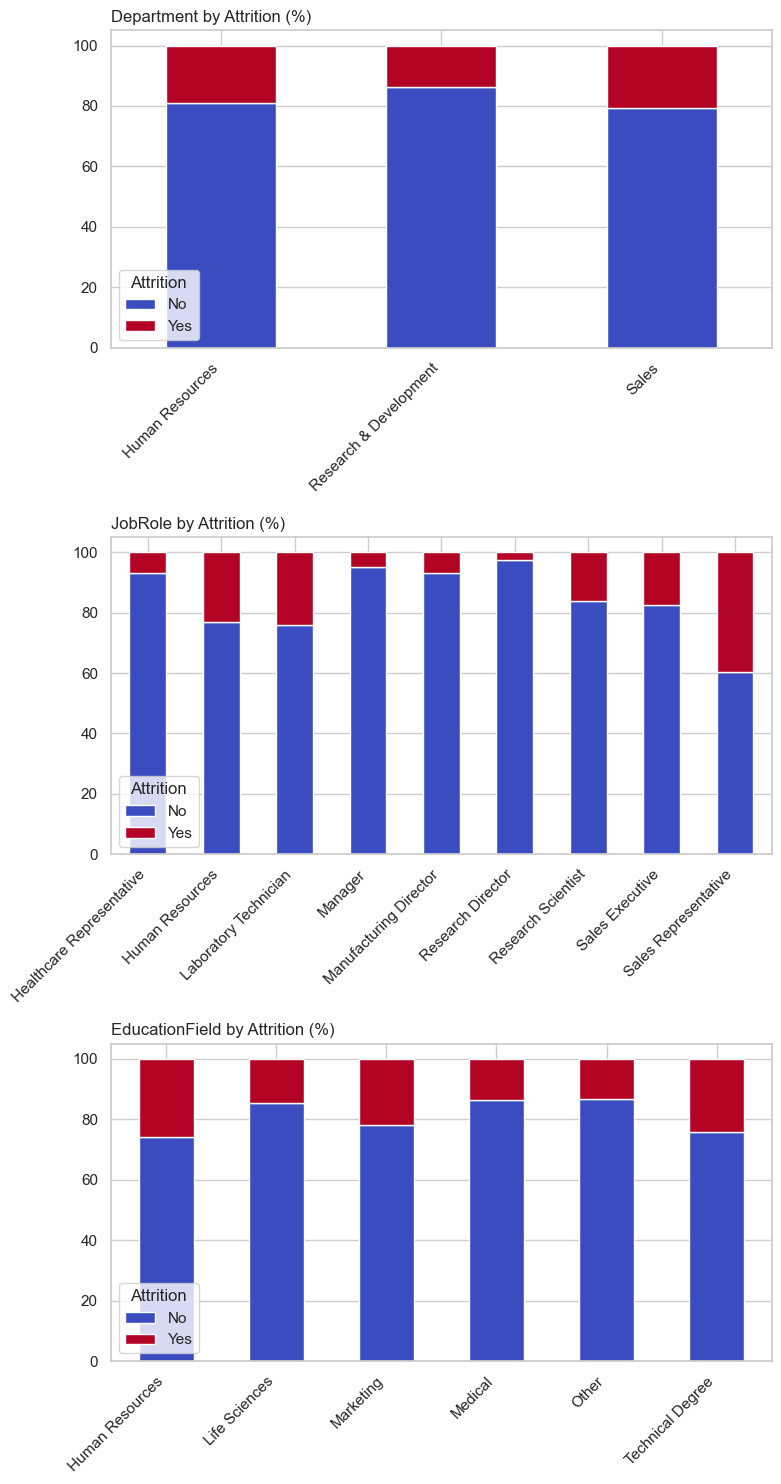

In [8]:
cols_role = ['Department', 'JobRole', 'EducationField']

fig, axes = plt.subplots(len(cols_role), 1, figsize=(8, 15))  # 3 rows, 1 column

for idx, col in enumerate(cols_role):
    cross_tab = pd.crosstab(df[col], df['Attrition'], normalize='index') * 100
    cross_tab.plot(kind='bar', stacked=True, colormap='coolwarm', ax=axes[idx])
    
    axes[idx].set_title(f'{col} by Attrition (%)', loc='left')
    axes[idx].set_xlabel("")
    axes[idx].set_ylabel("")
    axes[idx].tick_params(axis='x', rotation=45)
    
    for label in axes[idx].get_xticklabels():
        label.set_ha('right')
    
    axes[idx].legend(title='Attrition', loc='lower left')

plt.tight_layout()
plt.show()

#### Demographics

- These bar plots present attrition rates segmented by `Gender` and `MaritalStatus`:
  - `Gender`: The proportion of attrition appears relatively consistent across genders, with both `Female` and `Male` employees exhibiting similar attrition percentages. This suggests that gender may not be a strong differentiator for predicting attrition in this dataset.
  - `MaritalStatus`: Attrition varies more notably across marital status groups. Employees who are `Single` have a visibly higher attrition rate compared to those who are `Married` or `Divorced`. This trend may reflect lifestyle or financial stability differences that affect retention likelihood.

- `MaritalStatus` shows moderate potential as a predictive feature for attrition, particularly highlighting `Single` status as a potential risk factor. `Gender`, in contrast, provides limited signal and may not contribute much value in isolation.

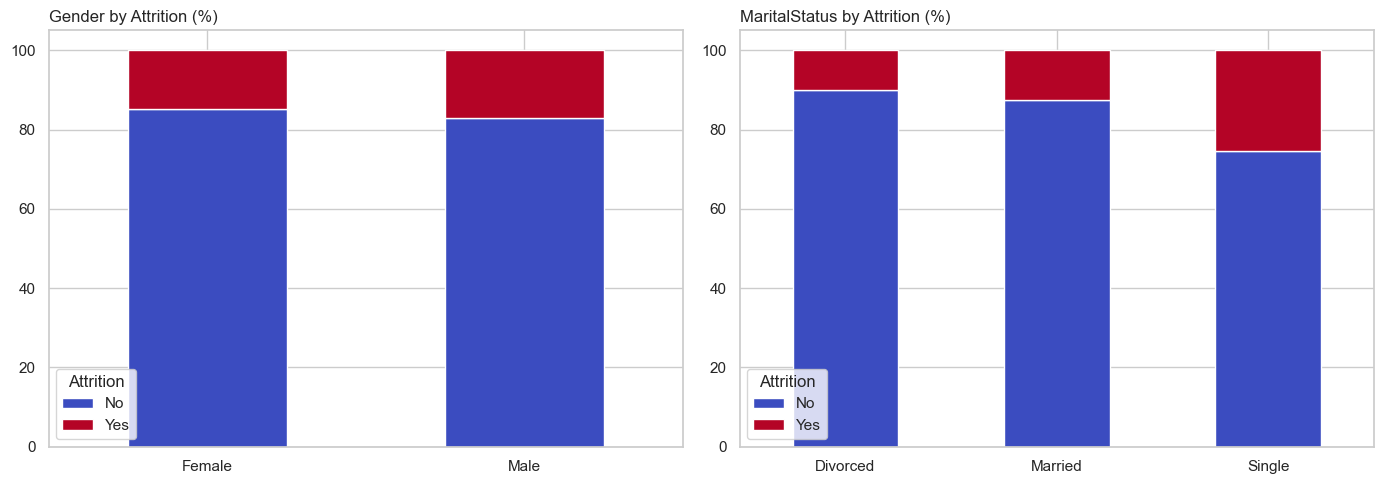

In [20]:
cols_demo = ['Gender', 'MaritalStatus']

fig, axes = plt.subplots(1, len(cols_demo), figsize=(14, 5))

for idx, col in enumerate(cols_demo):
    cross_tab = pd.crosstab(df[col], df['Attrition'], normalize='index') * 100
    cross_tab.plot(kind='bar', stacked=True, colormap='coolwarm', ax=axes[idx])
    axes[idx].set_title(f'{col} by Attrition (%)', loc='left')
    axes[idx].set_xlabel("")
    axes[idx].set_ylabel("")
    axes[idx].tick_params(axis='x', rotation=0)  # No tilt
    axes[idx].legend(title='Attrition', loc='lower left')  # Legend bottom-left

plt.tight_layout()
plt.show()

#### Work pattern and attrition

- This section examines attrition patterns based on `BusinessTravel`, `OverTime`, `JobLevel`, and `StockOptionLevel`:
  - `BusinessTravel`: Employees who travel frequently show significantly higher attrition rates. Those who travel rarely or not at all have much lower attrition. This suggests that frequent travel may be a stressor or correlate with roles that experience higher turnover.
  - `OverTime`: There is a clear increase in attrition among employees who work overtime, reinforcing the idea that excessive workload contributes to dissatisfaction and departure.
  - `JobLevel`: Generally, attrition decreases as job level increases. Entry-level employees (`JobLevel` = 1) show the highest attrition, while mid to senior levels (3–5) show better retention. This aligns with the notion that higher-level positions offer more job stability or satisfaction.
  - `StockOptionLevel`: Employees with no stock options (0) have the highest attrition. Those with stock options at levels 1 to 3 show lower attrition, suggesting that equity incentives may help with retention. Notably, StockOptionLevel 3 has worse retention than levels 1 and 2. 
 
- `OverTime` and `BusinessTravel` are strong indicators of attrition, potentially pointing to work-life balance issues. `JobLevel` and `StockOptionLevel` show that seniority and equity incentives are associated with lower attrition, indicating the value of career progression and benefits in retaining employees.


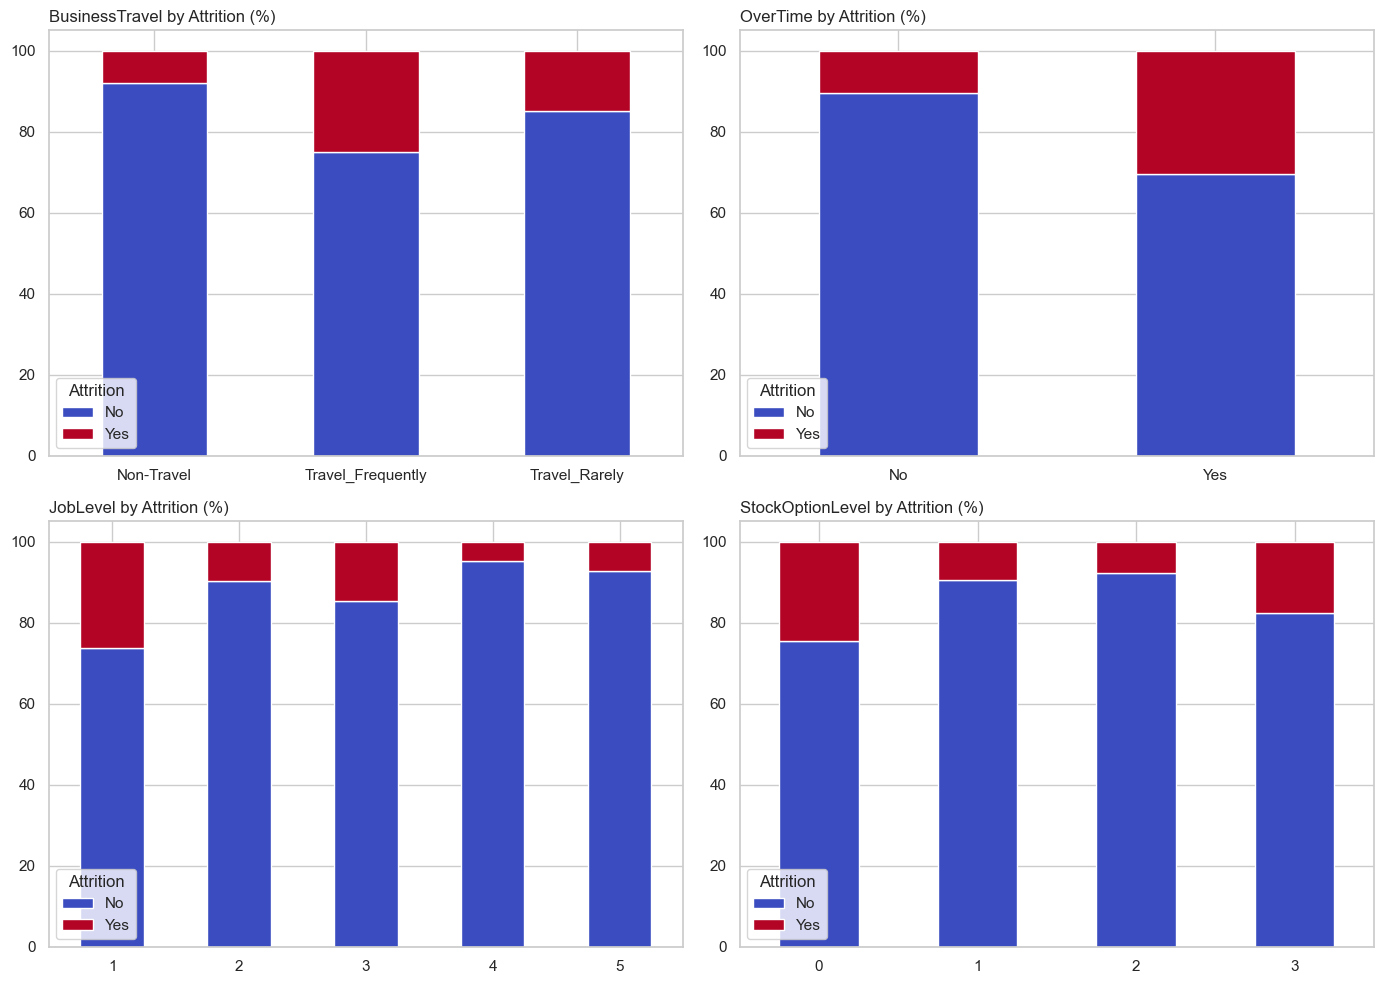

In [9]:
cols_work = ['BusinessTravel', 'OverTime', 'JobLevel', 'StockOptionLevel']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2 rows, 2 columns
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

for idx, col in enumerate(cols_work):
    cross_tab = pd.crosstab(df[col], df['Attrition'], normalize='index') * 100
    cross_tab.plot(kind='bar', stacked=True, colormap='coolwarm', ax=axes[idx])
    
    axes[idx].set_title(f'{col} by Attrition (%)', loc='left')
    axes[idx].set_xlabel("")
    axes[idx].set_ylabel("")
    axes[idx].tick_params(axis='x', rotation=0)  # horizontal x-tick labels
    axes[idx].legend(title='Attrition', loc='lower left')

plt.tight_layout()
plt.show()

## 6. Feature Correlation

- The correlation analysis revealed several strong linear relationships among numeric features, particularly in salary, job level, and tenure metrics. 
  - `JobLevel`, `MonthlyIncome`, and `TotalWorkingYears` were highly correlated, as were `YearsAtCompany`, `YearsInCurrentRole`, and `YearsWithCurrManager`. 
    - These patterns suggest potential redundancy in the data, which may be important to address depending on the modeling approach.

  - Conversely, satisfaction-related features (`JobSatisfaction`, `EnvironmentSatisfaction`) and rate-based features (`DailyRate`, `HourlyRate`) showed minimal correlation with other variables. These may capture unique aspects of employee experience and could contribute distinct predictive value in downstream models.

- Overall, this correlation check helps identify which features may be interdependent and informs decisions around feature selection and model design.


### Correlation Matrix

- We identify numeric feature pairs with high absolute correlation (|corr| > 0.7):
  - `JobLevel` and `MonthlyIncome` are very strongly correlated (`r = 0.95`), reflecting income growth with seniority.
  - `MonthlyIncome`, and `TotalWorkingYears` also have a strong correlation with each other and with `JobLevel`, indicating experience drives both level and pay.
  - `PercentSalaryHike` and `PerformanceRating` (`r = 0.77`) suggests salary increases align with performance.
  - Tenure-related features (`YearsAtCompany`, `YearsInCurrentRole`, `YearsWithCurrManager`) are tightly linked (`r = 0.71–0.76`).

- These correlations may indicate feature redundancy, which will be dealt with by dropping or combining features.


In [22]:
# Identify numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns

# Compute correlation matrix for numeric features
corr_matrix = df[numeric_cols].corr()

# Display top correlated feature pairs (absolute value > 0.7, excluding self-correlations)
high_corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
high_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_corr_pairs['AbsCorr'] = high_corr_pairs['Correlation'].abs()
high_corr_pairs = high_corr_pairs[high_corr_pairs['AbsCorr'] > 0.7].sort_values(by='AbsCorr', ascending=False)

print("Highly correlated numeric feature pairs (|corr| > 0.7):")
display(high_corr_pairs)

Highly correlated numeric feature pairs (|corr| > 0.7):


,Feature 1,Feature 2,Correlation,AbsCorr
134,JobLevel,MonthlyIncome,0.950300,0.950300
141,JobLevel,TotalWorkingYears,0.782208,0.782208
198,PercentSalaryHike,PerformanceRating,0.773550,0.773550
168,MonthlyIncome,TotalWorkingYears,0.772893,0.772893
249,YearsAtCompany,YearsWithCurrManager,0.769212,0.769212
247,YearsAtCompany,YearsInCurrentRole,0.758754,0.758754
251,YearsInCurrentRole,YearsWithCurrManager,0.714365,0.714365


### Correlation Heatmap

#### Strong Correlations (|r| > 0.7)
- `JobLevel` and `MonthlyIncome` show a very strong positive correlation (`r ≈ 0.95`), consistent with expectations that higher-level roles command higher salaries.
- `MonthlyIncome` also correlates strongly with `TotalWorkingYears` (`r ≈ 0.77`), suggesting that compensation increases significantly with tenure.
- `JobLevel` and `TotalWorkingYears` are similarly correlated (`r ≈ 0.78`), indicating that experience is associated with career progression.
- `YearsAtCompany`, `YearsInCurrentRole`, `YearsWithCurrManager` all show strong mutual correlations (`r ≈ 0.71–0.76`), reflecting the natural overlap in tenure-related features.
- `PercentSalaryHike` and `PerformanceRating` have a strong correlation (`r ≈ 0.77`), implying that salary adjustments are performance-based.

#### Moderate Correlations (|r| ≈ 0.4–0.7)
- `Age` shows moderate correlation with `TotalWorkingYears` (`r ≈ 0.66`), which is logical given that older employees have had more time to accumulate experience.
- `YearsAtCompany` and `TotalWorkingYears` are moderately correlated, but not perfectly so, suggesting job changes between companies.
- `YearsSinceLastPromotion` correlates moderately with `YearsInCurrentRole` and `YearsAtCompany`, which could reflect stagnant roles or infrequent promotions.
- `JobLevel` shows some moderate correlation with `YearsAtCompany`, indicating that promotions are linked to company tenure.

#### Weak or Minimal Correlations (|r| < 0.3)
- Features like `EnvironmentSatisfaction`, `RelationshipSatisfaction`, `JobSatisfaction`, and `WorkLifeBalance` show weak or negligible correlation with most other numeric variables. 
  - This suggests they are likely orthogonal to quantitative career metrics and may provide independent value in modeling.
  
- `HourlyRate`, `DailyRate`, and `MonthlyRate` are not strongly correlated with each other or with `MonthlyIncome`, which may indicate inconsistent or non-standard compensation structures in the dataset.
- `DistanceFromHome` shows little to no correlation with tenure, income, or satisfaction-related metrics.

#### Negative Correlations
- Some weak negative correlations are visible, such as between `YearsSinceLastPromotion` and `PerformanceRating`, which may imply recent promotions are linked to better performance.
  

### Summary

The dataset contains several tightly correlated variables, especially around compensation (`MonthlyIncome`, `JobLevel`, `TotalWorkingYears`) and tenure (`YearsAtCompany`, `YearsInCurrentRole`, `YearsWithCurrManager`). 
While tree-based models can handle multicollinearity well, linear models may benefit from dimensionality reduction or feature selection to avoid redundancy.
Variables such as satisfaction scores and distance from home appear to capture distinct aspects of the employee profile, and may serve as valuable predictors in modeling attrition or job satisfaction despite their weak correlation with traditional career metrics.


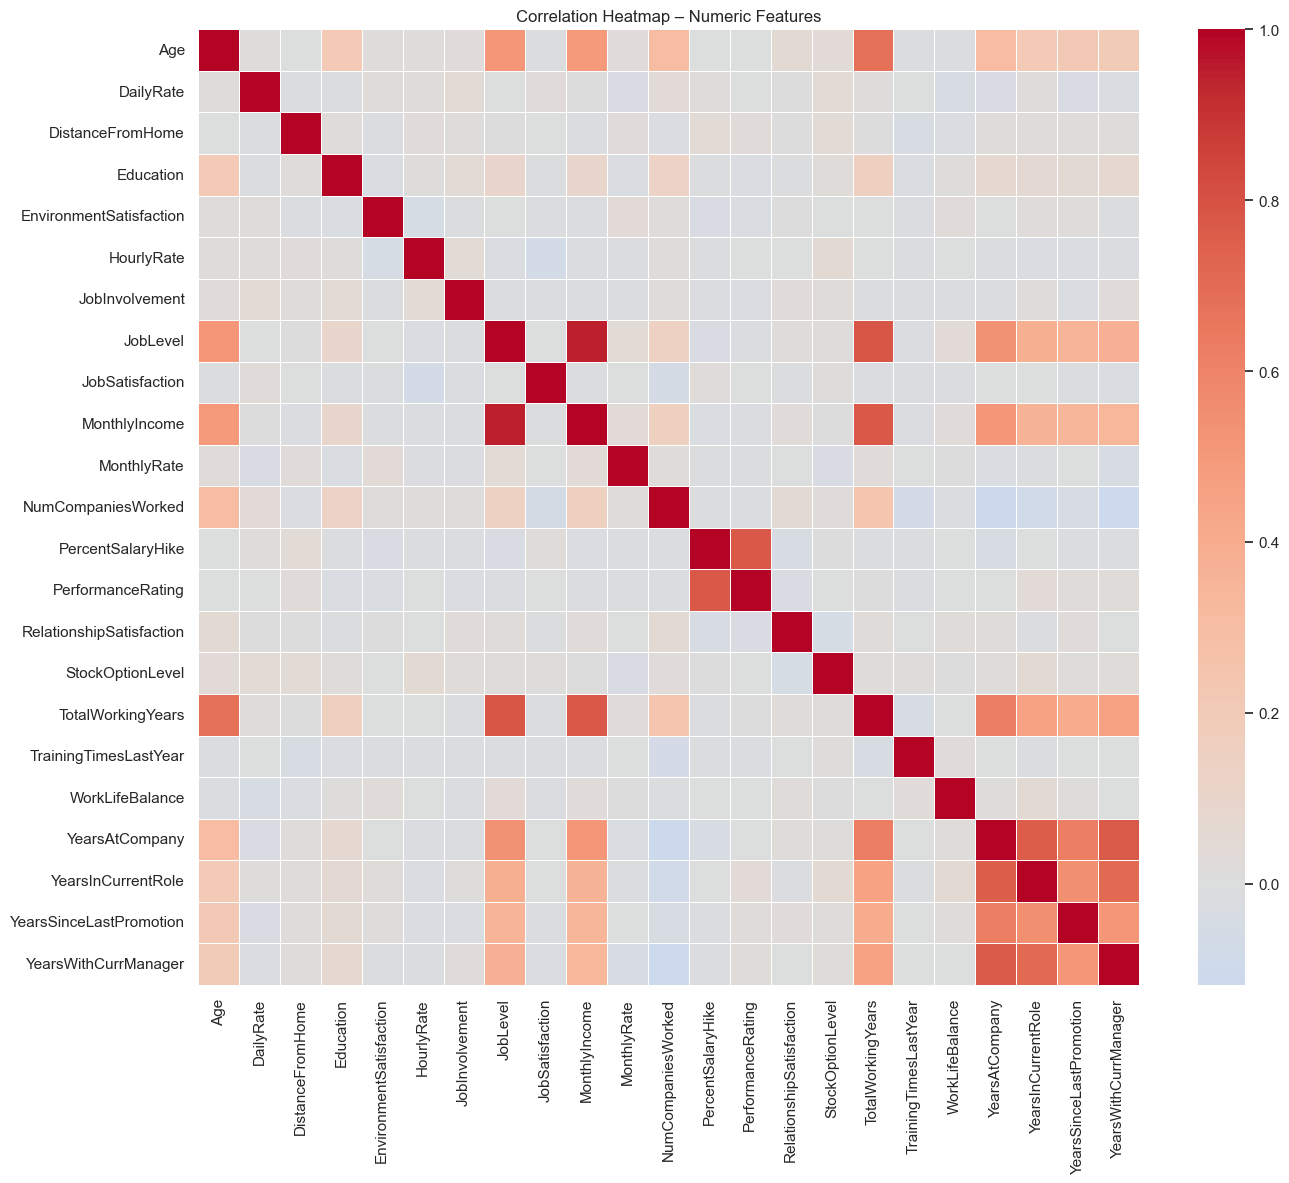

In [23]:
# Heatmap of correlations
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Correlation Heatmap – Numeric Features")
plt.tight_layout()
plt.show()

# EDA Summary and Next Steps

### Key Insights from EDA:

- **Target Imbalance**: Only ~16% of employees in the dataset have `Attrition = Yes`, indicating significant class imbalance. Future modeling should use metrics like ROC-AUC or recall instead of just accuracy.

- **Strong Predictors Identified**:
  - Employees who work **OverTime** are nearly 3× more likely to leave.
  - **Low JobSatisfaction**, **shorter tenure** (`YearsAtCompany`), and **low WorkLifeBalance** are also associated with higher attrition.
  - **Younger employees**, **low income**, and those in certain **JobRoles** (e.g. Sales, Laboratory Technician) appear to be more likely to leave.

- **Feature Quality**:
  - No missing values or duplicates detected.
  - All columns passed structure validation.
  - `EmployeeCount`, `StandardHours`, and `Over18` show no variance and will likely be dropped in preprocessing.
  - No negative or illogical values in numeric fields.

- **Correlation Observations**:
  - Some features (e.g., `MonthlyIncome` vs. `JobLevel`) are highly correlated and may introduce multicollinearity in linear models.
  - No extreme outliers, but skew exists in some numeric distributions (e.g. `MonthlyRate`).

### Next Steps:

1. **Encode categorical variables** appropriately for modeling.
2. **Scale numeric features** if using distance-based or linear models.
3. **Stratify training/test split** to preserve class imbalance.
4. **Prepare data for model interpretability**.

The dataset appears clean and predictive, with several strong features that are both statistically and intuitively linked to attrition. We are ready to move into preprocessing and model development.
